<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [17]:
import dotenv
import wandb
import os

dotenv.load_dotenv(os.path.join("/homes/55/bwilop/wsg/private/", "vscode-ssh.env"))
api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=api_key)
WANDB_ENTITIY = "benwilop-rwth-aachen-university"

data_folder = "/homes/55/bwilop/wsg/data/"
experiment_folder = "/homes/55/bwilop/wsg/experiments/"
crosscoder_folder = experiment_folder + "tictactoe/crosscoder/"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc


In [30]:
%load_ext autoreload
%autoreload 2
import json
import torch as t
from torch.utils.data import DataLoader, TensorDataset
import datetime
from typing import Iterator

# from jaxtyping import Float
import matplotlib.pyplot as plt

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
print(DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


# Load Data & Models

In [19]:
project_name_pretrain = "tictactoe/tictactoe_pretraining5"
project_name_finetune = "tictactoe/tictactoe_finetuning5"
weak_model_size = "small"
strong_model_size = "medium"
index = 2

# Load data
(
    tictactoe_train_data,
    tictactoe_weak_finetune_data,
    tictactoe_val_data,
    tictactoe_test_data,
) = load_split_data(data_folder + "tictactoe/", device=DEVICE, index=index)

# Load models
weak_model = load_model(
    project_name_pretrain,
    weak_model_size,
    Goal.WEAK_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
strong_baseline_model = load_model(
    project_name_pretrain,
    strong_model_size,
    Goal.WEAK_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
strong_model = load_model(
    project_name_pretrain,
    strong_model_size,
    Goal.STRONG_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
finetuned_model = load_finetuned_model(
    project_name_finetune,
    weak_model_size,
    strong_model_size,
    experiment_folder,
    DEVICE,
    index,
)

# Print evaluations
(
    weak_loss,
    _,
) = quick_evaluation("weak_model", weak_model, tictactoe_test_data)
strong_baseline_loss, _ = quick_evaluation(
    "strong_baseline_model", strong_baseline_model, tictactoe_test_data
)
quick_evaluation("strong_model", strong_model, tictactoe_test_data)
weak_finetuned_loss, _ = quick_evaluation(
    "finetuned_model", finetuned_model, tictactoe_test_data
)
print(
    "Performance Gap Recovered (PGR): ",
    (weak_loss - weak_finetuned_loss) / (weak_loss - strong_baseline_loss),
)

experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_small_weak_2025-05-16-16-35_ayyrg2xq.pkl
Moving model to device:  cuda
experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_weak_2025-05-16-16-35_eif67e03.pkl
Moving model to device:  cuda
experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_strong_2025-05-16-16-44_omyjjb73.pkl
Moving model to

In [20]:
from dictionary_learning.dictionary_learning import CrossCoder
from dictionary_learning.dictionary_learning.dictionary import BatchTopKCrossCoder
from dictionary_learning.dictionary_learning.trainers.crosscoder import (
    BatchTopKCrossCoderTrainer,
)
from dictionary_learning.dictionary_learning.training import trainSAE
from dictionary_learning.dictionary_learning.cache import (
    PairedActivationCache,
    ActivationCache,
    ActivationShard,
)
import transformer_lens.utils as utils

In [21]:
def get_activations(
    model,
    tokenized_games: Float[Tensor, "n_games game_length"],
    layer_i: int,
) -> Float[Tensor, "n_games game_length d_model"]:
    activation_hook_name = utils.get_act_name("resid_post", layer_i)
    model.eval()
    _, cache = model.run_with_cache(tokenized_games)
    layer_activations = cache[activation_hook_name]
    return layer_activations

In [22]:
activation_hook_name = utils.get_act_name("resid_post", 1)
print(activation_hook_name)

blocks.1.hook_resid_post


In [23]:
@t.no_grad()
def create_data_shards(
    games_data: Float[Tensor, "n_games game_length"],
    model: HookedTransformer,
    store_dir: str,
    batch_size: int = 64,
    shard_size: int = 10**6,
    max_total_tokens: int = 10**8,
    overwrite: bool = False,
) -> None:
    dataloader = DataLoader(games_data, batch_size=batch_size)
    io: str = "out"
    submodule_names = [f"layer_{layer_i}" for layer_i in range(model.cfg.n_layers)]

    activation_cache = [[] for _ in submodule_names]
    store_dirs = [
        os.path.join(store_dir, f"{submodule_names[layer_i]}_{io}")
        for layer_i in range(len(submodule_names))
    ]
    for store_dir in store_dirs:
        os.makedirs(store_dir, exist_ok=True)
    total_size = 0
    current_size = 0
    shard_count = 0

    # Check if shards already exist
    if os.path.exists(os.path.join(store_dirs[0], "shard_0.memmap")):
        print(f"Shards already exist in {store_dir}")
        if not overwrite:
            print("Set overwrite=True to overwrite existing shards.")
            return
        else:
            print("Overwriting existing shards...")

    print("Collecting activations...")
    for games in tqdm(dataloader, desc="Collecting activations"):
        for layer_i in range(len(submodule_names)):
            local_activations = rearrange(
                get_activations(model, games, layer_i)
            )  # (B x T) x D
            activation_cache[layer_i].append(local_activations.cpu())

        current_size += activation_cache[0][-1].shape[0]
        if current_size > shard_size:
            print(f"Storing shard {shard_count}...", flush=True)
            ActivationCache.collate_store_shards(
                store_dirs,
                shard_count,
                activation_cache,
                submodule_names,
                shuffle_shards=True,
                io=io,
                multiprocessing=False,
            )
            shard_count += 1
            total_size += current_size
            current_size = 0
            activation_cache = [[] for _ in submodule_names]

        if total_size > max_total_tokens:
            print("Max total tokens reached. Stopping collection.")
            break

    if current_size > 0:
        ActivationCache.collate_store_shards(
            store_dirs,
            shard_count,
            activation_cache,
            submodule_names,
            shuffle_shards=True,
            io=io,
            multiprocessing=False,
        )

    # store configs
    for i, store_dir in enumerate(store_dirs):
        with open(os.path.join(store_dir, "config.json"), "w") as f:
            json.dump(
                {
                    "batch_size": batch_size,
                    "context_len": -1,
                    "shard_size": shard_size,
                    "d_model": model.cfg.d_model,
                    "shuffle_shards": True,
                    "io": io,
                    "total_size": total_size,
                    "shard_count": shard_count,
                    "store_tokens": False,
                },
                f,
            )
    ActivationCache.cleanup_multiprocessing()
    print(f"Finished collecting activations. Total size: {total_size}")

In [24]:
def get_activations_path(
    model_goal: Goal | None,
    weak_model_size: str | None,
    model_size: str,
    index: int,
    crosscoder_folder: str,
    train_val: str,
) -> str:
    assert model_goal is None or weak_model_size is None
    assert model_goal is not None or weak_model_size is not None
    if weak_model_size:
        postfix = "finetuned_through_" + weak_model_size
    elif model_goal in [Goal.WEAK_GOAL, Goal.STRONG_GOAL]:
        postfix = str(model_goal)
    else:
        raise ValueError(f"Invalid activations model goal: {model_goal}")
    return os.path.join(
        crosscoder_folder, "activations", f"{index}_{model_size}_{postfix}_" + train_val
    )


def compute_activations(
    model_goal: Goal | None,
    project_name_pretrain: str | None,
    weak_model_size: str | None,
    project_name_finetune: str | None,
    model_size: str,
    index: int,
    crosscoder_folder: str,
    tictactoe_test_data: Float[Tensor, "n_games game_length"],
    tictactoe_val_data: Float[Tensor, "n_games game_length"],
    experiment_folder: str,
) -> None:
    # Either finetuned or pretrained
    bool_finetuned_model = (
        project_name_finetune is not None and weak_model_size is not None
    )
    bool_pretrained_model = project_name_pretrain is not None and model_goal is not None
    assert int(bool_finetuned_model) + int(bool_pretrained_model) == 1, (
        f"Finetuned XOR pretrained model must be provided."
    )

    # Models
    if bool_finetuned_model:
        model = load_finetuned_model(
            project_name_finetune,
            weak_model_size,
            model_size,
            experiment_folder,
            DEVICE,
            index,
        )
    else:
        model = load_model(
            project_name_pretrain,
            model_size,
            model_goal,
            experiment_folder,
            device=DEVICE,
            index=index,
        )

    # Run
    for train_val in ["train", "val"]:
        if train_val == "train":
            games_data = tictactoe_test_data
        elif train_val == "val":
            games_data = tictactoe_val_data
        else:
            raise ValueError(f"Invalid train_val: {train_val}")

        activations_path = get_activations_path(
            model_goal, weak_model_size, model_size, index, crosscoder_folder, train_val
        )
        create_data_shards(
            games_data,
            model,
            store_dir=activations_path,
            batch_size=64,
            shard_size=10**5,
            max_total_tokens=10**10,
            overwrite=False,
        )

In [25]:
# Strong
compute_activations(
    Goal.STRONG_GOAL,
    project_name_pretrain,
    None,
    None,
    strong_model_size,
    index,
    crosscoder_folder,
    tictactoe_test_data.games_data,
    tictactoe_val_data.games_data,
    experiment_folder,
)

# Finetuned
compute_activations(
    None,
    None,
    weak_model_size,
    project_name_finetune,
    strong_model_size,
    index,
    crosscoder_folder,
    tictactoe_test_data.games_data,
    tictactoe_val_data.games_data,
    experiment_folder,
)

experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_strong_2025-05-16-16-44_omyjjb73.pkl
Moving model to device:  cuda
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_strong_train/layer_3_out
Set overwrite=True to overwrite existing shards.
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_strong_val/layer_3_out
Set overwrite=True to overwrite existing shards.
Moving model to device:  cuda
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_finetuned_through_small_train/layer_3_out
Set overwrite=True to overwrite existing shards.
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medi

In [26]:
def multi_epoch_dataloader_iterator(dataloader: DataLoader, total_steps_to_yield: int):
    """
    A generator that yields batches from a DataLoader repeatedly until
    total_steps_to_yield is reached. Re-shuffles if dataloader.shuffle=True.
    """
    # Edge cases
    if total_steps_to_yield == 0:  # No steps
        return
    try:
        if len(dataloader) == 0 and total_steps_to_yield > 0:  # Empty dataloader
            print(
                "Warning: DataLoader is empty, but total_steps_to_yield > 0. No steps will run."
            )
            return
    except TypeError:  # no __len__
        pass

    steps_yielded = 0
    while steps_yielded < total_steps_to_yield:
        num_batches_this_epoch = 0
        for batch in dataloader:  # DataLoader shuffles here if its shuffle=True
            if steps_yielded >= total_steps_to_yield:
                return
            yield batch
            steps_yielded += 1
            num_batches_this_epoch += 1

        # Safeguard, if the dataloader gets empty for any reason, it would be an infinite loop otherwise
        if num_batches_this_epoch == 0 and steps_yielded < total_steps_to_yield:
            print("Warning: DataLoader became empty before all steps were yielded.")
            return

In [27]:
def get_training_cfg_cross_coder():
    training_cfg_cross_coder = {
        "learning_rate": 1e-3,
        "max_steps": 20000,
        "validate_every_n_steps": 1000,
        "batch_size": 64,
        "expansion_factor": 32,
        "k": 10,
    }
    return training_cfg_cross_coder


def train_crosscoder(
    model_0_name: str,
    model_1_name: str,
    index: int,
    train_activations_stor_dir_model_0: str,
    val_activations_stor_dir_model_0: str,
    train_activations_stor_dir_model_1: str,
    val_activations_stor_dir_model_1: str,
    layer: int,
    training_cfg_cross_coder: dict,
    wandb_entity: str,
    device: t.device = DEVICE,
) -> None:
    # Save arguments
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
    experiment_name = f"experiment_{index}_{model_0_name}_{model_1_name}_{timestamp}"
    save_dir = crosscoder_folder + "checkpoints/" + experiment_name
    train_crosscoder_args = {
        "model_0_name": model_0_name,
        "model_1_name": model_1_name,
        "index": index,
        "layer": layer,
        "training_cfg_cross_coder": training_cfg_cross_coder,
        "data_path": {
            "train_activations_stor_dir_model_0": train_activations_stor_dir_model_0,
            "val_activations_stor_dir_model_0": val_activations_stor_dir_model_0,
            "train_activations_stor_dir_model_1": train_activations_stor_dir_model_1,
            "val_activations_stor_dir_model_1": val_activations_stor_dir_model_1,
        },
    }
    save_dir = os.path.join(crosscoder_folder, "checkpoints", experiment_name)
    os.makedirs(save_dir, exist_ok=True)
    with open(
        os.path.join(save_dir, "train_crosscoder_args.json"), "w", encoding="utf-8"
    ) as json_file:
        json.dump(train_crosscoder_args, json_file)

    # Data (not loaded in memory yet)
    train_dataset = PairedActivationCache(
        train_activations_stor_dir_model_0,
        train_activations_stor_dir_model_1,
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=training_cfg_cross_coder["batch_size"],
        shuffle=True,
        num_workers=1,
        pin_memory=True,
    )
    print(f"Training on {len(train_dataset)} token activations.")
    val_dataset = PairedActivationCache(
        val_activations_stor_dir_model_0,
        val_activations_stor_dir_model_1,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=1000,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
    )
    print(f"Validating on {len(val_dataset)} token activations.")

    # Training config
    activation_dim = train_dataset[0].shape[1]
    dictionary_size = training_cfg_cross_coder["expansion_factor"] * activation_dim
    print(f"Activation dim: {activation_dim}")
    print(f"Dictionary size: {dictionary_size}")
    k = training_cfg_cross_coder["k"]
    lr = training_cfg_cross_coder["learning_rate"]
    max_steps = training_cfg_cross_coder["max_steps"]

    # Top level of trainer_cfg: BatchTopKCrossCoderTrainer
    # dict_class_kwargs: CrossCoder
    trainer_cfg = {
        "trainer": BatchTopKCrossCoderTrainer,
        "activation_dim": activation_dim,
        "dict_size": dictionary_size,
        "lr": lr,
        "device": str(device),
        "wandb_name": experiment_name + f"L{layer}-k{k:.1e}-lr{lr:.0e}",  #
        "steps": max_steps,  # Also used below, I think because it is needed here for learning rate and in trainSAE just for loop termination
        "k": k,  # 'k' as a top-level argument for the trainer
        "layer": layer,  # Only for logging
        "lm_name": experiment_name,  # Only for logging
        # "dict_class_kwargs": {
        # },
    }
    # train the sparse autoencoder (SAE)
    wandb.finish()
    multi_epoch_train_dataloader = multi_epoch_dataloader_iterator(
        train_dataloader, max_steps
    )
    trainSAE(
        data=multi_epoch_train_dataloader,
        trainer_config=trainer_cfg,
        validate_every_n_steps=training_cfg_cross_coder["validate_every_n_steps"],
        validation_data=val_dataloader,
        use_wandb=True,
        wandb_entity=wandb_entity,
        wandb_project="crosscoder",
        log_steps=50,
        save_dir=save_dir,
        steps=max_steps,
        save_steps=None,
    )

In [28]:
layer = 3

model_0_name = "strong_model"
model_1_name = "finetuned_model"

train_activations_stor_dir_model_0 = get_activations_path(
    Goal.STRONG_GOAL, None, strong_model_size, index, crosscoder_folder, "train"
)
val_activations_stor_dir_model_0 = get_activations_path(
    Goal.STRONG_GOAL, None, strong_model_size, index, crosscoder_folder, "val"
)
train_activations_stor_dir_model_1 = get_activations_path(
    None, weak_model_size, strong_model_size, index, crosscoder_folder, "train"
)
val_activations_stor_dir_model_1 = get_activations_path(
    None, weak_model_size, strong_model_size, index, crosscoder_folder, "val"
)
training_cfg_cross_coder = get_training_cfg_cross_coder()
# train_crosscoder(
#     model_0_name,
#     model_1_name,
#     index,
#     train_activations_stor_dir_model_0 + f"/layer_{layer}_out",
#     val_activations_stor_dir_model_0 + f"/layer_{layer}_out",
#     train_activations_stor_dir_model_1 + f"/layer_{layer}_out",
#     val_activations_stor_dir_model_1 + f"/layer_{layer}_out",
#     layer,
#     training_cfg_cross_coder,
#     WANDB_ENTITIY,
#     DEVICE,
# )

Computing beta of model 1:   0%|          | 0/101 [00:00<?, ?it/s]

Computing beta of model 2:   0%|          | 0/101 [00:00<?, ?it/s]

Delta norms plot saved to /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-24-15-40/delta_norms.png
Betas plot saved to /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-24-15-40/betas_histogram.png
Nu plot saved to /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-24-15-40/nu_plot_jointgrid.png


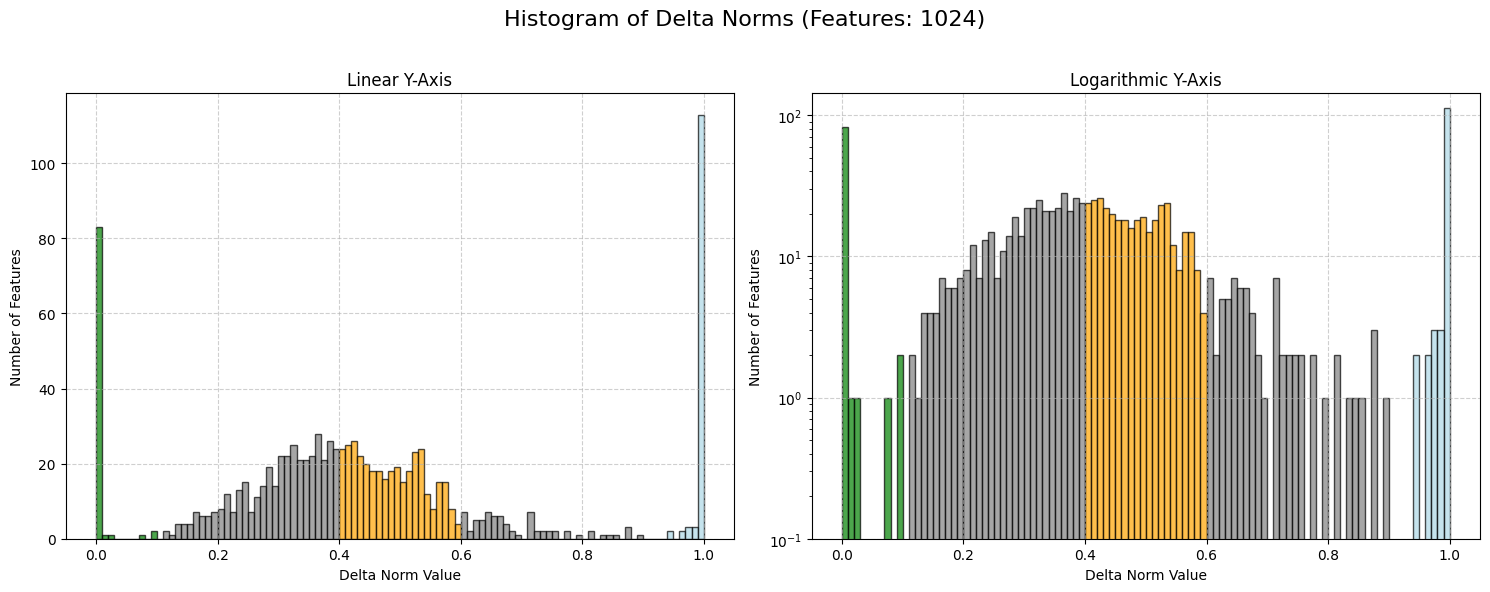

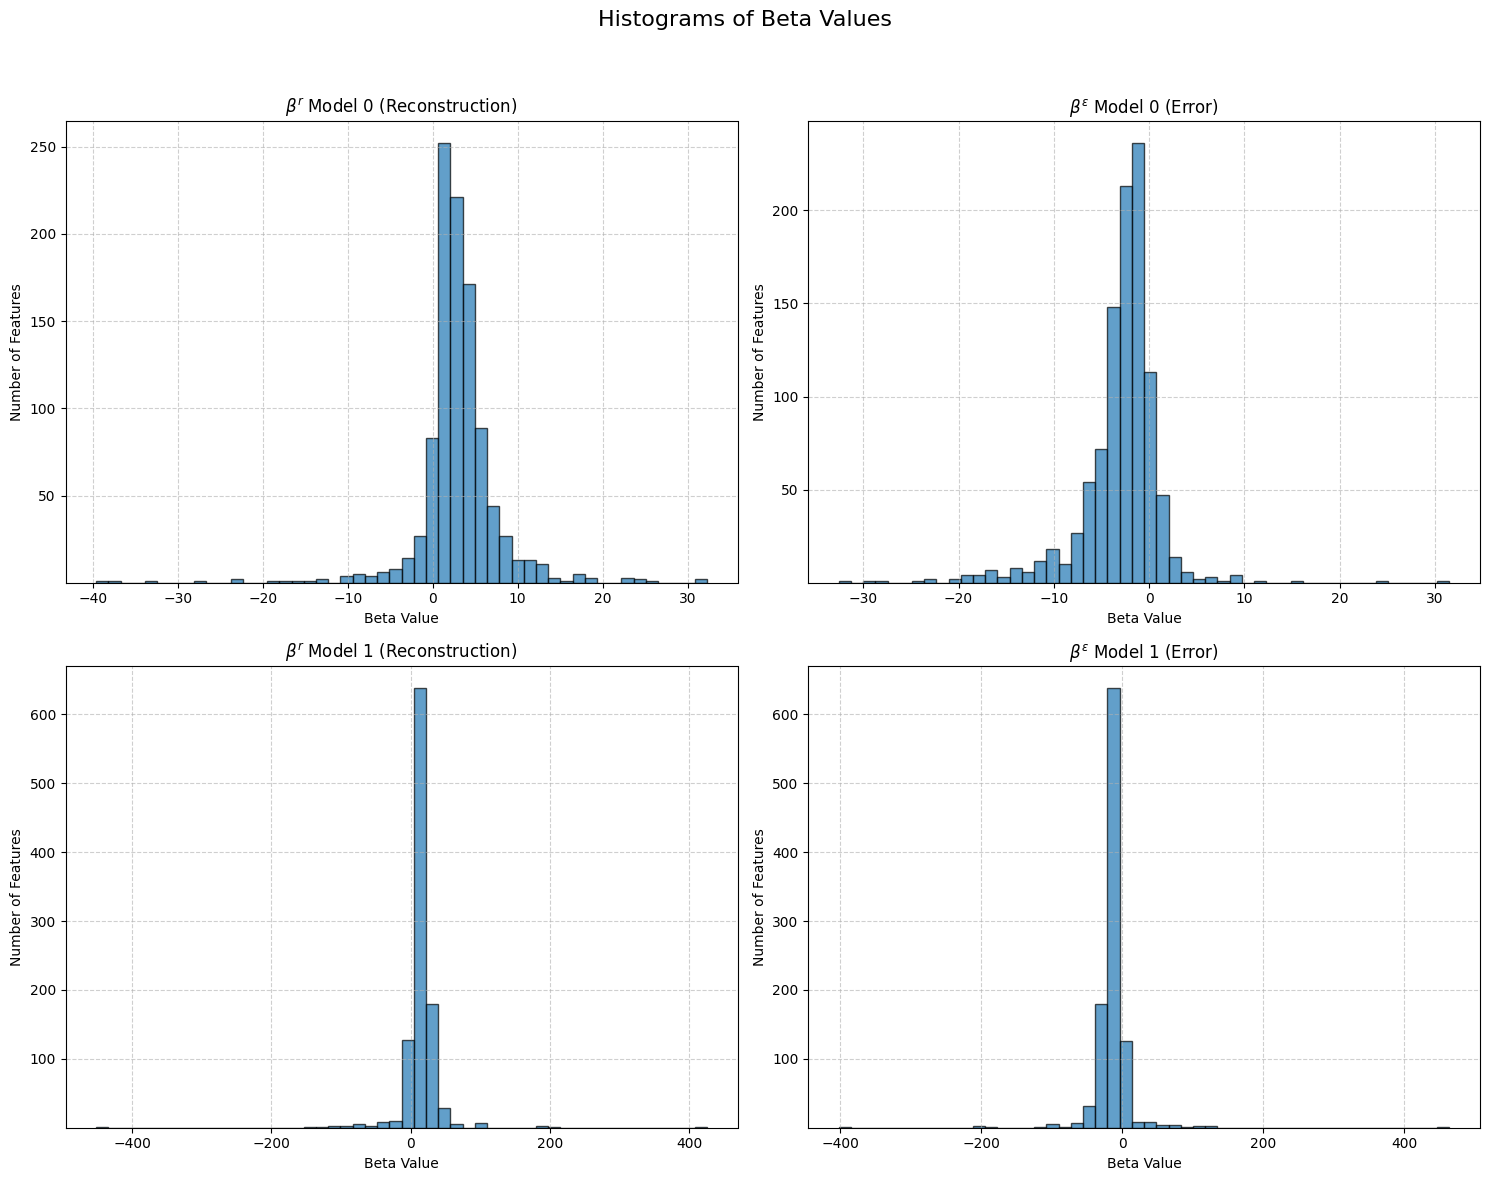

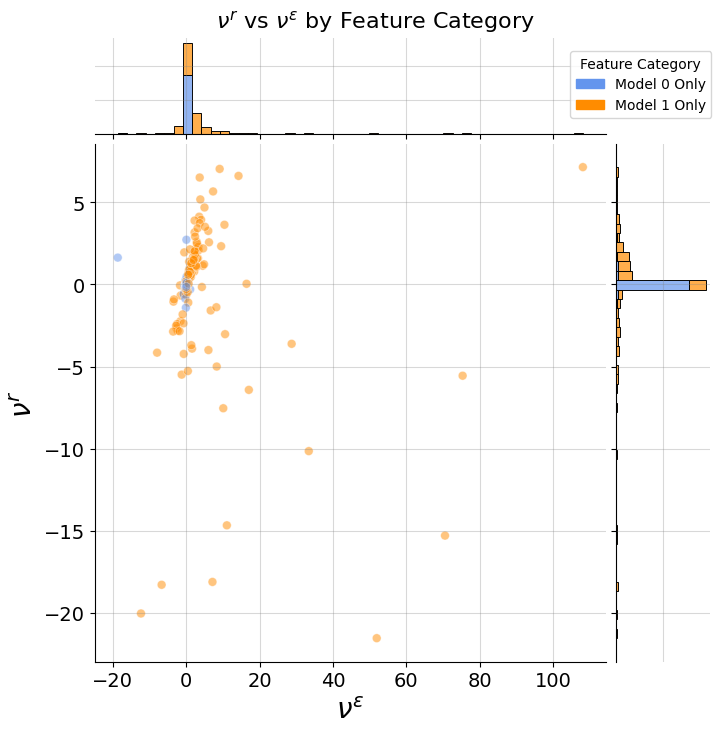

In [31]:
@dataclass
class CrosscoderMetrics:
    save_dir: str
    device: t.device
    train_crosscoder_args: dict
    config: dict
    crosscoder: BatchTopKCrossCoder
    delta_norms: Float[Tensor, "n_activations"]
    beta_reconstruction_model_0: Float[Tensor, "n_activations"]
    beta_reconstruction_model_1: Float[Tensor, "n_activations"]
    beta_error_model_0: Float[Tensor, "n_activations"]
    beta_error_model_1: Float[Tensor, "n_activations"]
    nu_reconstruction: Float[Tensor, "n_activations"]
    nu_error: Float[Tensor, "n_activations"]

    def __init__(self, save_dir: str, device: t.device) -> None:
        self.save_dir = save_dir
        self.device = device
        self.train_crosscoder_args = self.load_train_crosscoder_args(save_dir)
        self.config = self.load_config(self.save_dir)
        self.crosscoder = self.load_model(self.save_dir, device)
        self.delta_norms = self.compute_delta_norms()
        self.beta_reconstruction_model_0, self.beta_error_model_0 = self.compute_beta(
            model_i=0, device=self.device
        )
        self.beta_reconstruction_model_1, self.beta_error_model_1 = self.compute_beta(
            model_i=1, device=self.device
        )
        self.nu_reconstruction = (
            self.beta_reconstruction_model_0 / self.beta_reconstruction_model_1
        )
        self.nu_error = self.beta_error_model_0 / self.beta_error_model_1
        self.plot_delta_norms()
        self.plot_betas()
        self.plot_nu()

    # Save + Load
    def save(self, save_dir: str) -> None:
        path = os.path.join(save_dir, "crosscoder_metric.pt")
        with open(path, "wb") as f:
            pickle.dump(self, f)

    def _load_helper(path: str):
        if os.path.exists(path):
            with open(path, "rb") as f:
                data = pickle.load(f)
            return data
        else:
            raise FileNotFoundError(f"File {path} not found.")

    @staticmethod
    def load(save_dir: str):  # -> CrosscoderMetrics
        path = os.path.join(save_dir, "crosscoder_metric.pt")
        return CrosscoderMetrics._load_helper(path)

    @staticmethod
    def load_train_crosscoder_args(save_dir: str) -> dict:
        path = os.path.join(save_dir, "train_crosscoder_args.json")
        if os.path.exists(path):
            with open(path, "r") as f:
                return json.load(f)
        else:
            raise FileNotFoundError(f"File {path} not found.")

    @staticmethod
    def load_config(save_dir: str) -> dict:
        path = os.path.join(save_dir, "config.json")
        if os.path.exists(path):
            with open(path, "r") as f:
                data = json.load(f)
            return data.get("trainer", {})
        else:
            raise FileNotFoundError(f"File {path} not found.")

    @staticmethod
    def load_model(save_dir: str, device) -> CrossCoder:
        path = os.path.join(save_dir, "model_final.pt")
        if os.path.exists(path):
            return BatchTopKCrossCoder.from_pretrained(path, device=device)
        else:
            raise FileNotFoundError(f"File {path} not found.")

    def compute_delta_norms(
        self, epsilon: float = 0.0001
    ) -> Float[Tensor, "n_activations"]:
        d_model_0_vectors = self.crosscoder.decoder.weight[0]
        d_model_1_vectors = self.crosscoder.decoder.weight[1]
        norm_sq_model1 = t.sum(d_model_0_vectors**2, dim=-1)
        norm_sq_model2 = t.sum(d_model_1_vectors**2, dim=-1)
        max_norms_sq = t.maximum(norm_sq_model1, norm_sq_model2)

        delta_norms = 0.5 * (
            (norm_sq_model2 - norm_sq_model1) / (max_norms_sq + epsilon) + 1.0
        )
        return delta_norms.cpu()

    def _activations_both_generator(self, tqdm_desc) -> Iterator[t.Tensor]:
        val_dataset = PairedActivationCache(
            self.train_crosscoder_args["data_path"]["val_activations_stor_dir_model_0"],
            self.train_crosscoder_args["data_path"]["val_activations_stor_dir_model_1"],
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=1000,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
        )
        for activations_both in tqdm(val_dataloader, desc=tqdm_desc):
            # Move activations_both to device
            activations_model_0_dev = activations_both[0].to(self.device)
            activations_model_1_dev = activations_both[1].to(self.device)
            activations_both = t.stack(
                [activations_model_0_dev, activations_model_1_dev], dim=1
            )
            yield activations_both

    def compute_beta(
        self, model_i: int, device: t.device
    ) -> tuple[Float[Tensor, "n_activations"], Float[Tensor, "n_activations"]]:
        """
        beta = (d.T @ (Y.T @ F)) / (||d||^2 * ||f||^2)
        """
        D = self.crosscoder.decoder.weight[model_i]
        D_chat_norms_sq = D.square().sum(dim=1)  # ||D_j||_2, [dictionary_size]

        # Accumulators for sums over all samples, for each latent j.
        # numer_r[j] = sum_samples_i ( F[i,j] * <d_j, Y_reconstruction_target[i,:]> )
        # numer_e[j] = sum_samples_i ( F[i,j] * <d_j, Y_error_target[i,:]> )
        # sum_F_sq[j] = sum_samples_i ( F[i,j]^2 ) (this is ||f_j||^2 from the formula)
        dict_size = D.shape[0]
        numer_r = t.zeros(dict_size, device=device, dtype=t.float32)  # [dict_size]
        numer_e = t.zeros_like(numer_r)  # [dict_size]
        sum_F_sq = t.zeros_like(numer_r)  # [dict_size]

        self.crosscoder.eval()
        with t.no_grad():
            for activations_both in self._activations_both_generator(
                f"Computing beta of model {model_i + 1}"
            ):
                reconstructions_both, F_batch = self.crosscoder.forward(
                    activations_both, output_features=True
                )
                activations = activations_both[
                    :, model_i, :
                ]  # [batch_size, activation_dim]
                reconstructions = reconstructions_both[
                    :, model_i, :
                ]  # [batch_size, activation_dim]

                # F_batch: sparse feature activations from sae.encode.
                sum_F_sq += F_batch.square().sum(
                    dim=0
                )  # [dict_size] (F_batch is [batch_size, dict_size])

                # Determine target Y for reconstruction (Y_r) and error (Y_e)
                # Y_r, Y_e have shape (batch_size, activation_dim)
                Y_r = reconstructions
                Y_e = activations - Y_r

                # Accumulate numerators: sum_i F[i,j] * <d_j, Y_target[i,:]>
                # (Y_target @ D.T) gives <Y_target[i,:], d_j> for each sample i and latent j  # [batch_size, dict_size]
                numer_r += (F_batch * (Y_r @ D.T)).sum(dim=0)  # [dict_size]
                numer_e += (F_batch * (Y_e @ D.T)).sum(dim=0)  # [dict_size]

        # Denominator for beta_j = ||f_j||^2 * ||d_j||^2)
        denominators = sum_F_sq * D_chat_norms_sq  # [dict_size]

        beta_r = t.nan_to_num(numer_r / denominators, nan=1.0, posinf=1.0, neginf=1.0)
        beta_e = t.nan_to_num(numer_e / denominators, nan=1.0, posinf=1.0, neginf=1.0)

        return beta_r, beta_e

    def get_delta_thresholds(
        self, threshold_only: float = 0.1, threshold_shared: float = 0.1
    ):
        """
        Returns the thresholds for delta norms based on the provided parameters.
        """
        threshold_model_0_only = threshold_only
        threshold_model_1_only = 1 - threshold_only
        threshold_shared_lower = 0.5 - threshold_shared
        threshold_shared_upper = 0.5 + threshold_shared
        assert (
            threshold_model_0_only
            < threshold_shared_lower
            < threshold_shared_upper
            < threshold_model_1_only
        ), (
            f"Invalid thresholds: {threshold_model_0_only}, {threshold_shared_lower}, {threshold_shared_upper}, {threshold_model_1_only}"
        )
        return (
            threshold_model_0_only,
            threshold_model_1_only,
            threshold_shared_lower,
            threshold_shared_upper,
        )

    def plot_delta_norms(self) -> tuple[plt.Figure, list[plt.Axes]]:
        """
        Plots a histogram of delta norms with two subplots: one with linear y-axis and one with logarithmic y-axis.
        Linear same as in https://arxiv.org/pdf/2504.02922
        """
        (
            threshold_model_0_only,
            threshold_model_1_only,
            threshold_shared_lower,
            threshold_shared_upper,
        ) = self.get_delta_thresholds()

        # Data
        data_to_plot = self.delta_norms.detach().numpy()
        bins = np.linspace(0, 1, 101)  # 100 bins from 0 to 1, [0, 0.01, 0.02, ..., 1.0]

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(
            f"Histogram of Delta Norms (Features: {len(data_to_plot)})", fontsize=16
        )
        titles = ["Linear Y-Axis", "Logarithmic Y-Axis"]
        y_scales = ["linear", "log"]
        for i, ax in enumerate(axes):
            counts, _, patches = ax.hist(
                data_to_plot, bins=bins, edgecolor="black", alpha=0.7
            )
            bin_centers = (bins[:-1] + bins[1:]) / 2
            for count, patch, bin_center in zip(counts, patches, bin_centers):
                if bin_center <= threshold_model_0_only:
                    patch.set_facecolor("green")
                elif bin_center >= threshold_model_1_only:
                    patch.set_facecolor("lightblue")
                elif threshold_shared_lower <= bin_center <= threshold_shared_upper:
                    patch.set_facecolor("orange")
                else:
                    patch.set_facecolor("grey")

            ax.set_title(titles[i])
            ax.set_xlabel("Delta Norm Value")
            ax.set_ylabel("Number of Features")
            ax.set_yscale(y_scales[i])
            if y_scales[i] == "log":
                ax.set_ylim(bottom=0.1)  # Avoid log(0)
            ax.grid(True, linestyle="--", alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save plot
        filename = f"delta_norms.png"
        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)
            save_path = os.path.join(self.save_dir, filename)
            try:
                fig.savefig(save_path)
                print(f"Delta norms plot saved to {save_path}")
            except Exception as e:
                print(f"Error saving plot: {e}")

        return fig, axes

    def plot_betas(self) -> tuple[plt.Figure, list[plt.Axes]]:
        """Plots a 2x2 grid of histograms for beta values."""
        beta_data = {
            r"$\beta^r$ Model 0 (Reconstruction)": self.beta_reconstruction_model_0.cpu()
            .detach()
            .numpy(),
            r"$\beta^\epsilon$ Model 0 (Error)": self.beta_error_model_0.cpu()
            .detach()
            .numpy(),
            r"$\beta^r$ Model 1 (Reconstruction)": self.beta_reconstruction_model_1.cpu()
            .detach()
            .numpy(),
            r"$\beta^\epsilon$ Model 1 (Error)": self.beta_error_model_1.cpu()
            .detach()
            .numpy(),
        }

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle("Histograms of Beta Values", fontsize=16)
        axes = axes.flatten()

        for i, (title, data) in enumerate(beta_data.items()):
            ax = axes[i]
            if len(data) > 0:
                ax.hist(data, bins=50, edgecolor="black", alpha=0.7)
                ax.set_title(title)
                ax.set_xlabel("Beta Value")
                ax.set_ylabel("Number of Features")
                ax.grid(True, linestyle="--", alpha=0.6)
                # ax.set_yscale('log')
                ax.set_ylim(bottom=0.1)
            else:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.set_title(title)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        if self.save_dir:
            filename = "betas_histogram.png"
            os.makedirs(self.save_dir, exist_ok=True)
            save_path = os.path.join(self.save_dir, filename)
            try:
                fig.savefig(save_path)
                print(f"Betas plot saved to {save_path}")
            except Exception as e:
                print(f"Error saving betas plot: {e}")
        # plt.show() # Uncomment to display
        return fig, axes

    def plot_nu(self):
        """
        Plots nu_error vs nu_reconstruction, colored by delta_norm categories,
        Same as in https://arxiv.org/pdf/2504.02922
        """
        # Data
        nu_e_data = self.nu_error.cpu().detach().numpy()
        nu_r_data = self.nu_reconstruction.cpu().detach().numpy()
        delta_norms_data = self.delta_norms.cpu().detach().numpy()

        # Categories for each feature $j$
        (
            threshold_model_0_only,
            threshold_model_1_only,
            threshold_shared_lower,
            threshold_shared_upper,
        ) = self.get_delta_thresholds()
        categories = []
        for dn in delta_norms_data:
            if dn <= threshold_model_0_only:
                categories.append("Model 0 Only")
            elif dn >= threshold_model_1_only:
                categories.append("Model 1 Only")
            elif threshold_shared_lower <= dn <= threshold_shared_upper:
                categories.append("Shared")
            else:
                categories.append("Other")

        df = pd.DataFrame(
            {
                r"$\nu^\epsilon$ (Error)": nu_e_data,
                r"$\nu^r$ (Reconstruction)": nu_r_data,
                "Category": categories,
            }
        )

        # Plot
        palette = {
            "Model 0 Only": "cornflowerblue",
            "Shared": "grey",
            "Model 1 Only": "darkorange",
            "Other": "lightgrey",
        }
        categories_to_display = ["Model 0 Only", "Model 1 Only"]
        df_plot = df[
            df["Category"].isin(categories_to_display)
        ].copy()  # Use .copy() to avoid SettingWithCopyWarning
        if df_plot.empty:
            print("No data to plot for the selected categories in plot_nu.")
            fig, ax = plt.subplots()
            ax.text(
                0.5, 0.5, "No data for selected categories", ha="center", va="center"
            )
            if self.save_dir:
                plt.savefig(os.path.join(self.save_dir, "nu_plot_nodata.png"))
            return fig  # Return an empty figure or handle appropriately

        g = sns.JointGrid(
            data=df_plot,
            x=r"$\nu^\epsilon$ (Error)",
            y=r"$\nu^r$ (Reconstruction)",
            hue="Category",  # Hue is set on the grid
            height=7,
            ratio=5,  # Ratio of joint plot size to marginal plot size
            space=0.1,  # Space between joint and marginal plots
        )
        g.plot_joint(sns.scatterplot, palette=palette, s=40, alpha=0.5, legend=False)
        g.plot_marginals(
            sns.histplot,
            palette=palette,
            bins=50,
            multiple="stack",
            alpha=0.7,
            legend=False,
        )
        g.set_axis_labels(r"$\nu^\epsilon$", r"$\nu^r$", fontsize=20)
        plt.suptitle(
            r"$\nu^r$ vs $\nu^\epsilon$ by Feature Category", fontsize=16, y=1.02
        )
        ordered_cats_in_plot = [
            cat for cat in categories_to_display if cat in df_plot["Category"].unique()
        ]
        handles = [
            plt.Rectangle((0, 0), 1, 1, color=palette[cat])
            for cat in ordered_cats_in_plot
            if cat in palette
        ]
        labels = ordered_cats_in_plot
        if handles:
            g.fig.legend(
                handles,
                labels,
                title="Feature Category",
                loc="upper right",
                bbox_to_anchor=(0.99, 0.97),
            )

        # Style adjustments
        g.ax_joint.grid(True, linestyle="-", alpha=0.3, color="gray")
        g.ax_marg_x.grid(True, linestyle="-", alpha=0.3, color="gray")
        g.ax_marg_y.grid(True, linestyle="-", alpha=0.3, color="gray")
        g.ax_joint.tick_params(axis="both", which="major", labelsize=14)

        # g.ax_joint.set_xlim(0, 1.0)
        # g.ax_joint.set_ylim(0, 1.0)

        # Save plot
        if self.save_dir:
            filename = "nu_plot_jointgrid.png"
            os.makedirs(self.save_dir, exist_ok=True)
            save_path = os.path.join(self.save_dir, filename)
            try:
                # Use bbox_inches='tight' to prevent labels from being cut off
                g.fig.savefig(save_path, bbox_inches="tight", dpi=150)
                print(f"Nu plot saved to {save_path}")
            except Exception as e:
                print(f"Error saving nu plot: {e}")

        return g.fig


save_dir = "/homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-24-15-40"
val_dataloader = DataLoader(
    tictactoe_val_data.games_data,
    batch_size=1000,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)
crosscoder_metrics = CrosscoderMetrics(save_dir, DEVICE)